In [1]:
import math
import itertools
import random

import music21 as mc
import numpy as np

For machine learning applications we are interested in preprocessing MIDI files of different orchestra works into a simplified, standardized format:

* Quantize notes
* Transpose all notes (octaves) within a fixed range
* Convert parts to one time signature
* Reduce all parts to a fixed number

Through different techniques we want to augment the data:

* Transpose score to all keys (does not happen in this part)
* Through part reduction we deal with unused material, we use this material to generate new score material, changing the original score but keeping the "style" of the composition

In [2]:
# Input and output files
PATH_IN = './files/midi/symphony-2.mid'
PATH_OUT = './files/midi/symphony-2-converted.mid'

# Transpose all notes between this range
INTERVAL_NOTE = 'C'
INTERVAL_LOW = 3
INTERVAL_HIGH = 5

# Use these parameters for every part of the score
DEFAULT_TIME_SIGNATURE = '4/4'
DEFAULT_INSTRUMENT = 'piano'
DEFAULT_CLEF = 'treble'

# Quantize MIDI data before processing
QUANTIZATION = [4, 3]

# How many parts our output will contain
VOICE_NUM = 4

# How should the parts be distributed in %
VOICE_DISTRIBUTION = [0.2, 0.3, 0.3, 0.2]

# Parts with less than x percent of all notes get removed
SCORE_PART_RATIO = 0.01

In [3]:
def identify_instrument_name(stream):
    """Returns the instrument name of this part."""
    
    instruments = stream.getElementsByClass(mc.instrument.Instrument)
    if len(instruments) > 0 and instruments[0].instrumentName is not None:
        return instruments[0].instrumentName
    return 'Undefined'


def count_measures(part):
    """Returns the number of measures in given part."""
    
    return len(part.getElementsByClass(mc.stream.Measure))


def max_measures(score):
    """Find part with the highest amount of measures."""
    
    return max([count_measures(p) for p in score])

After import and quantization of the MIDI file, we check every single part of the score for its amount of notes in comparison to the whole score. If the ratio is very low (almost only empty staves) we ignore this part for later use (`SCORE_PART_RATIO`).

In [4]:
def remove_sparse_parts(score):
    """Remove parts which are too sparse."""
    
    original_parts_count = len(score)
    original_notes_count = len(score.flat.notes)
    removed_instruments = []
    
    for part in score:
        part_notes_count = len(part.flat.notes)
        if part_notes_count == 0:
            part_score_ratio = 0
        else:
            part_score_ratio = (part_notes_count / original_notes_count)

        if part_score_ratio < SCORE_PART_RATIO:
            removed_instruments.append(identify_instrument_name(part))
            score.remove(part)

    print('Removed {} part(s): {}, now {} given (original had {}).'.format(
        original_parts_count - len(score),
        removed_instruments,
        len(score),
        original_parts_count))

In [5]:
# Import MIDI file
score = mc.converter.parse(PATH_IN)

# Quantize MIDI data
score.quantize(QUANTIZATION,
               processOffsets=True,
               processDurations=True,
               inPlace=True)

# Clean up
remove_sparse_parts(score)

Removed 1 part(s): ['Trumpet'], now 11 given (original had 12).


To reduce all given parts to a smaller number we first analyze the ambitus of every part (not the instrument since this data might not always be correct) to then calculate a score (0 - 100%) of how likely this ambitus will fit into our new range based on `VOICE_DISTRIBUTION`.

In [6]:
def identify_ambitus_groups(score):
    """Finds out which parts of the score belong to which ambitus group."""
    
    print('Identify ambitus groups for all score parts ..')
    
    # 1. Analyze ambitus for every part
    part_intervals = []
    for part_index, part in enumerate(score):
        interval = mc.analysis.discrete.Ambitus().getSolution(part)
        part_intervals.append([part_index,
                               interval.noteStart.diatonicNoteNum,
                               interval.noteEnd.diatonicNoteNum])
        
    # 2. Identify minimum and maximum ambitus over all parts
    part_intervals = np.array(part_intervals)
    interval_min = np.min(part_intervals[:, 1])
    interval_max = np.max(part_intervals[:, 2])
    print('Score ambitus is {} - {} (min - max)!'.format(interval_min, interval_max))
    
    # 3. Calculate closeness for every part to our groups
    scores = []
    interval_total = interval_max - interval_min
    interval_slice = math.ceil(interval_total / VOICE_NUM)
    
    range_min = interval_min - 1
    for voice_index in range(0, VOICE_NUM):
        range_min = interval_min + (interval_slice * voice_index) + 1
        range_max = interval_min + (interval_slice * voice_index) + interval_slice
        for part_interval in part_intervals:
            part_index, part_min, part_max = part_interval
            closeness = abs(range_min - part_min) + abs(range_max - part_max)
            closeness = 1 - (closeness / (interval_total * 2))
            scores.append([part_index,
                           voice_index,
                           closeness])
         
    # 4. Group parts based on closeness
    part_groups = []
    groups_count = [0 for i in range(0, VOICE_NUM)]
    
    for part_interval in part_intervals:
        # Filter all closeness scores belonging to this part ...
        part_index = part_interval[0]
        part_scores = list(filter(lambda i: i[0] == part_index, scores))
        # ... sort them ...
        part_scores = sorted(part_scores, key=lambda i: i[2], reverse=True)
        # ... and take the group with the best score.
        group_index = part_scores[0][1]
        find_direction = True
        while groups_count[group_index] / len(part_intervals) > VOICE_DISTRIBUTION[group_index]:
            # Change group index when first choice was too full
            if group_index == VOICE_NUM - 1:
                find_direction = False
            elif group_index == 0:
                find_direction = True
            group_index += 1 if find_direction else -1
                
        part_groups.append(group_index)
        groups_count[group_index] += 1
    print('Parts in groups:', part_groups)
        
    return np.array(part_groups)

In [7]:
# Identify ambitus group for every part
part_groups = identify_ambitus_groups(score)

Identify ambitus groups for all score parts ..
Score ambitus is 10 - 45 (min - max)!
Parts in groups: [3, 2, 2, 1, 2, 1, 3, 2, 3, 1, 0]


Since we reduced the number of parts to x groups (`VOICE_NUM`) we will need to ignore original parts in the final score. To avoid this (and to augment our data), we don't throw away any unused parts but generate multiple scores in all different part combinations.

The combinations are calculated by first translating the part groups into a tree structure to then traverse the tree from bottom up, finding all possible combinations.

In [8]:
def create_combination_tree(options, group_index):
    """Convert all possible combinations into a tree data structure."""
    
    if len(options) - 1 < group_index:
        return None
    
    combinations = []
    
    for option in options[group_index]:
        combinations.append(option)
        results = create_combination_tree(options, group_index + 1)
        if results:
            combinations.append(results)
            
    return combinations


def traverse_combination_tree(tree, single_combination = [], result = [], depth = 0):
    """Traverse a tree to find all possible combinations."""
    
    if not hasattr(tree, '__len__'):
        return single_combination
    
    if depth == 0:
        result = []
        
    if len(tree) < 2:
        print('Warning: Not enough options given!')
        return
    
    for i in range(0, len(tree) - 1, 2):
        sub_tree = tree[i + 1]
        if not hasattr(sub_tree, '__len__'):
            for n in tree:
                result.append(
                    traverse_combination_tree(n,
                                              single_combination + [n],
                                              result,
                                              depth + 1))
        else:
            traverse_combination_tree(sub_tree,
                                      single_combination + [tree[i]],
                                      result,
                                      depth + 1)
            
    return result

In [9]:
# Check which parts we can combine
combination_options = []
for i in range(0, VOICE_NUM):
    combination_options.append(np.argwhere(part_groups == i).flatten())
    
# Build a tree to traverse to find all combinations
tree = create_combination_tree(combination_options, 0)
combinations = traverse_combination_tree(tree, single_combination = [])

print('Found {} possible combinations.'.format(len(combinations)))

Found 36 possible combinations.


To clean the original score from all uneeded data, we create a temporary new score and fill it with the most important informations from the original parts: Notes with pitch and rests. The notes are transposed (in octaves, see `INTERVAL_NOTE`, `INTERVAL_LOW` and `INTERVAL_HIGH`) within a defined interval. When chords occur we take the highest voice since we want our resulting score to be monophonic per part.

In [10]:
def generate_note_from_pitch(old_pitch):
    """Take a pitch object, transpose and generate a new note from it."""
    
    # Fit within interval range
    new_pitch = old_pitch.transposeAboveTarget(
        mc.pitch.Pitch(name=INTERVAL_NOTE, octave=INTERVAL_LOW))
    new_pitch = new_pitch.transposeBelowTarget(
        mc.pitch.Pitch(name=INTERVAL_NOTE, octave=INTERVAL_HIGH))

    # Choose the most commonly used enharmonic spelling
    new_pitch = new_pitch.simplifyEnharmonic(mostCommon=True)
    
    new_note = mc.note.Note(name=new_pitch.name,
                            octave=new_pitch.octave)
 
    return new_note


def create_default_part():
    """Creates a default part."""
    
    part = mc.stream.Part()

    # Set default instrument, time signature and clef
    part.insert(0, mc.instrument.fromString(DEFAULT_INSTRUMENT))
    part.insert(0, mc.meter.TimeSignature(DEFAULT_TIME_SIGNATURE))
    part.insert(0, mc.clef.clefFromString(DEFAULT_CLEF))
    
    return part

Convert part "Flute" in group 3 with 73 notes.
Convert part "Oboe" in group 2 with 59 notes.
Convert part "Clarinet" in group 2 with 52 notes.
Convert part "Bassoon" in group 1 with 32 notes.
Convert part "StringInstrument" in group 2 with 7 notes.
Convert part "Horn" in group 1 with 32 notes.
Convert part "StringInstrument" in group 3 with 115 notes.
Convert part "StringInstrument" in group 2 with 53 notes.
Convert part "StringInstrument" in group 3 with 92 notes.
Convert part "StringInstrument" in group 1 with 106 notes.
Convert part "StringInstrument" in group 0 with 48 notes.
Finalize score ..
Done!


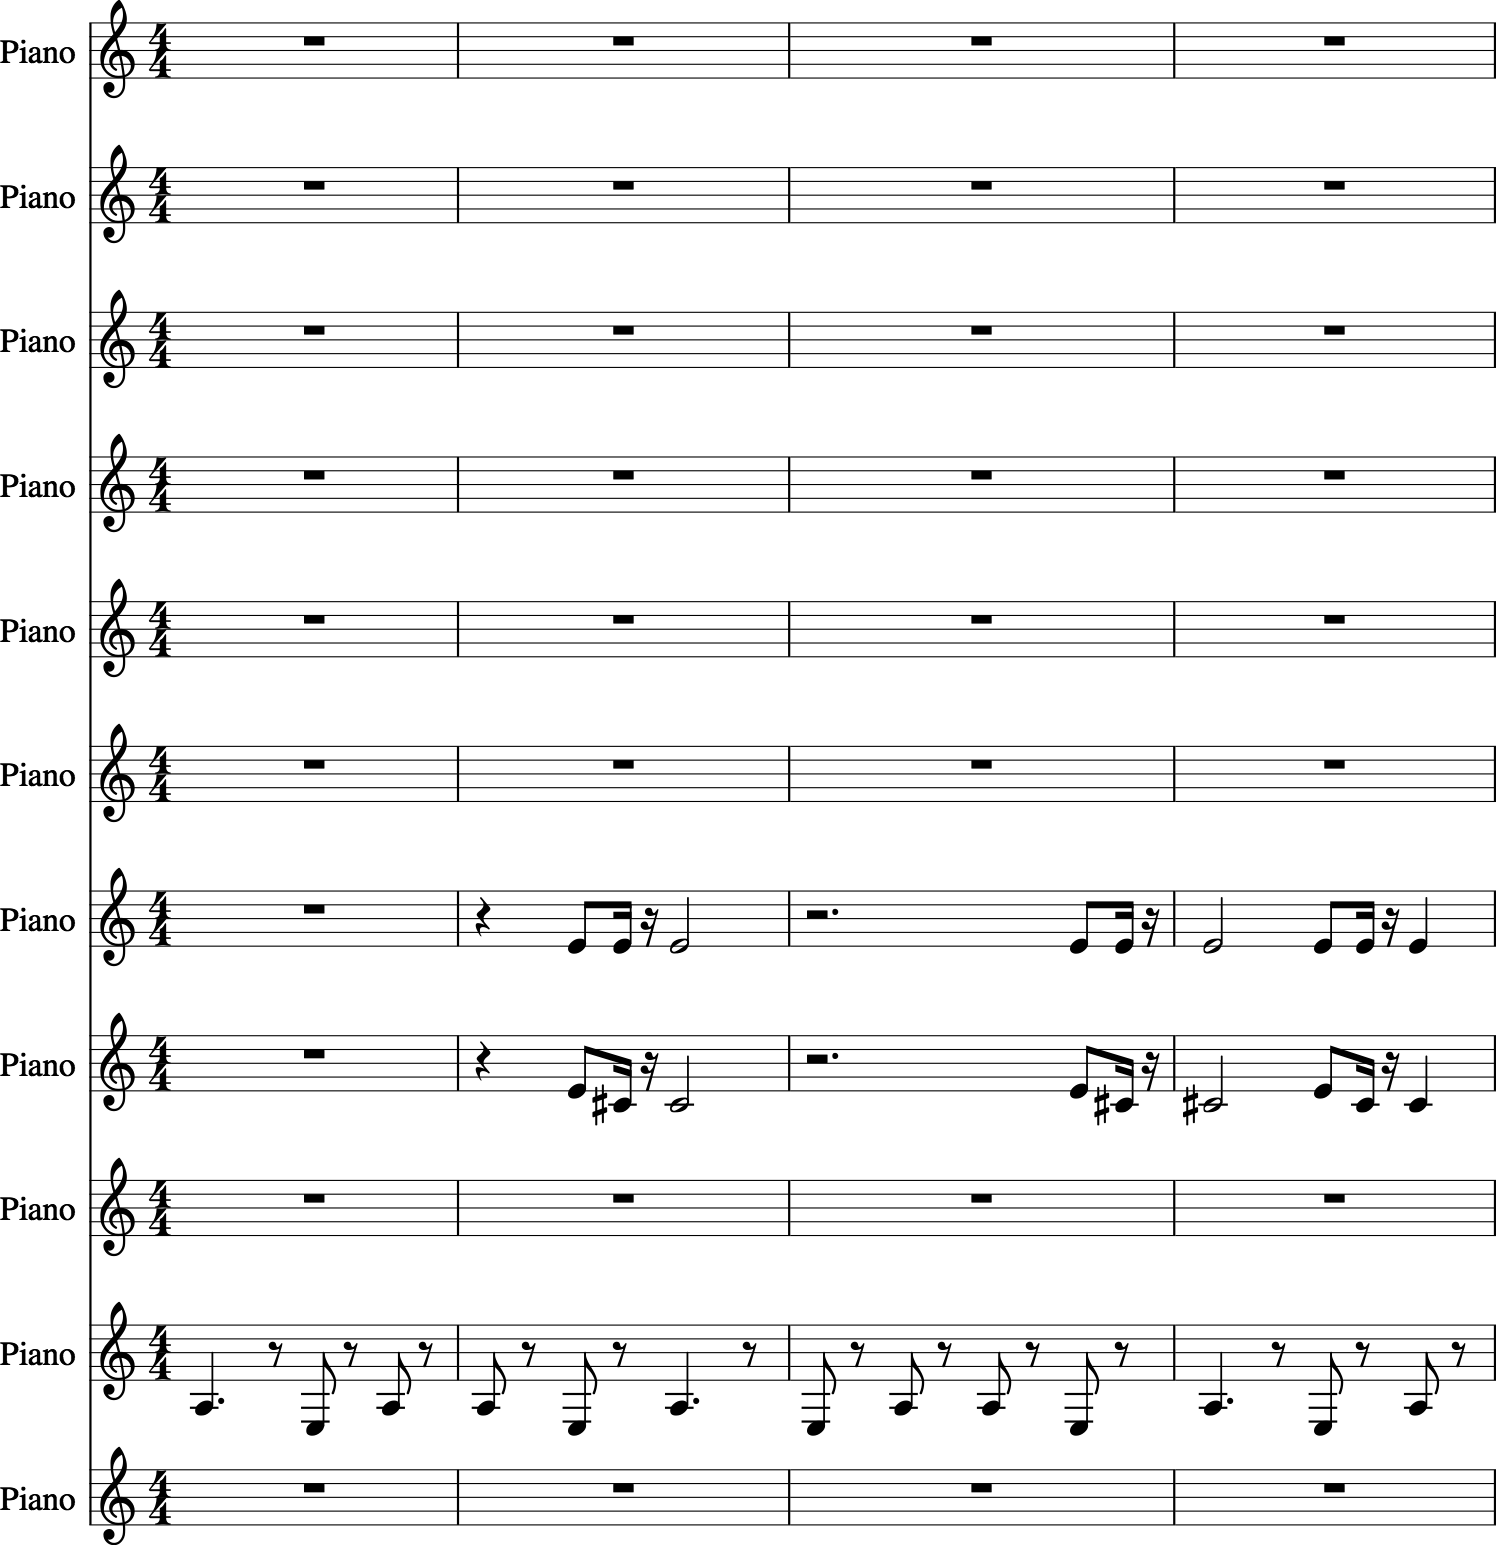

In [11]:
# Prepare temporary score
temp_score = mc.stream.Score()

# Convert all parts of score to new score
for part_index, part in enumerate(score):
    new_part = create_default_part()

    # Get group this part belongs to
    group_index = part_groups[part_index]

    # Get instrument name for this part for debugging
    instrument_name = identify_instrument_name(part)
    print('Convert part "{}" in group {} with {} notes.'.format(
        instrument_name, group_index, len(part.flat.notes)))

    # Convert notes and rests
    for element in part.flat.notesAndRests:
        if element.isNote:
            new_element = generate_note_from_pitch(element.pitch)
        elif element.isChord:
            new_element = generate_note_from_pitch(element.pitches[0])
        elif element.isRest:
            new_element = mc.note.Rest()
            
        new_element.quarterLength = element.quarterLength
        new_element.offset = element.offset

        new_part.append(new_element)

    temp_score.insert(0, new_part)

print('Finalize score ..')
temp_score.makeNotation(inPlace=True)
print('Done!')

temp_score.measures(1, 4).show()

Finally we can generate a new score based on our temporary score with cleaned original parts and the given possible combinations. All combinations are simply just added up, the score grows in this way and yields more data.

In [12]:
def clean_copy_measure(measure, relative_measure_index, duration):
    """Cleanly creates a new measure based on given one."""
    
    new_measure = mc.stream.Measure()
    new_measure.leftBarline = 'light-light' if relative_measure_index == 1 else None
    new_measure.rightBarline = None
    
    if measure is not None:
        # Add all notes and rests from given measure
        for element in measure.notesAndRests:
            new_measure.append(element)
    else:
        # Insert full rest if given measure does not exist
        new_rest = mc.note.Rest()
        new_rest.duration = duration
        new_measure.append(new_rest)
        
    return new_measure

In [16]:
# Calculate longest part in measures
measures_total = max_measures(temp_score)
measure_duration = temp_score[0].measure(1).barDuration
print('Longest part has {} measures (length = {} quarters).'.format(
    measures_total,
    measure_duration.quarterLength))

# Prepare a new score with empty parts for every voice
new_score = mc.stream.Score()
for i in range(0, VOICE_NUM):
    new_part = create_default_part()
    new_score.insert(0, new_part)

# Add parts in all possible combinations
for combination_index, combination in enumerate(combinations):
    # print('----------------------------')
    # print('combination', combination_index, combination)
    for relative_measure_index in range(1, measures_total + 1):
        measure_index = relative_measure_index + (combination_index * measures_total)
        offset = measure_duration.quarterLength * (measure_index - 1)
        # print('measure', relative_measure_index, measure_index, offset)
        for part_index, temp_part_index in enumerate(reversed(combination)):
            measure = temp_score[temp_part_index].measure(relative_measure_index)
            new_score[part_index].insert(
                offset,
                clean_copy_measure(measure,
                                   relative_measure_index,
                                   measure_duration))
            # print('- offset', offset, 'part index', part_index, 'temp part index', temp_part_index, 'rel. measure index', relative_measure_index)
    print('Generated combination {} #{}.'.format(combination,
                                                 combination_index + 1))

# Nice barlines at end of score
for part in new_score:
    part[-1].rightBarline = 'final'
    
# Finalize!
print('Finalize score ..')
new_score.makeNotation(inPlace=True)

print('Done! Generated score with {} measures.'.format(
    max_measures(new_score)))

Longest part has 32 measures (length = 4.0 quarters).
Generated combination [10, 3, 1, 0] #1.
Generated combination [10, 3, 1, 6] #2.
Generated combination [10, 3, 1, 8] #3.
Generated combination [10, 3, 2, 0] #4.
Generated combination [10, 3, 2, 6] #5.
Generated combination [10, 3, 2, 8] #6.
Generated combination [10, 3, 4, 0] #7.
Generated combination [10, 3, 4, 6] #8.
Generated combination [10, 3, 4, 8] #9.
Generated combination [10, 3, 7, 0] #10.
Generated combination [10, 3, 7, 6] #11.
Generated combination [10, 3, 7, 8] #12.
Generated combination [10, 5, 1, 0] #13.
Generated combination [10, 5, 1, 6] #14.
Generated combination [10, 5, 1, 8] #15.
Generated combination [10, 5, 2, 0] #16.
Generated combination [10, 5, 2, 6] #17.
Generated combination [10, 5, 2, 8] #18.
Generated combination [10, 5, 4, 0] #19.
Generated combination [10, 5, 4, 6] #20.
Generated combination [10, 5, 4, 8] #21.
Generated combination [10, 5, 7, 0] #22.
Generated combination [10, 5, 7, 6] #23.
Generated co

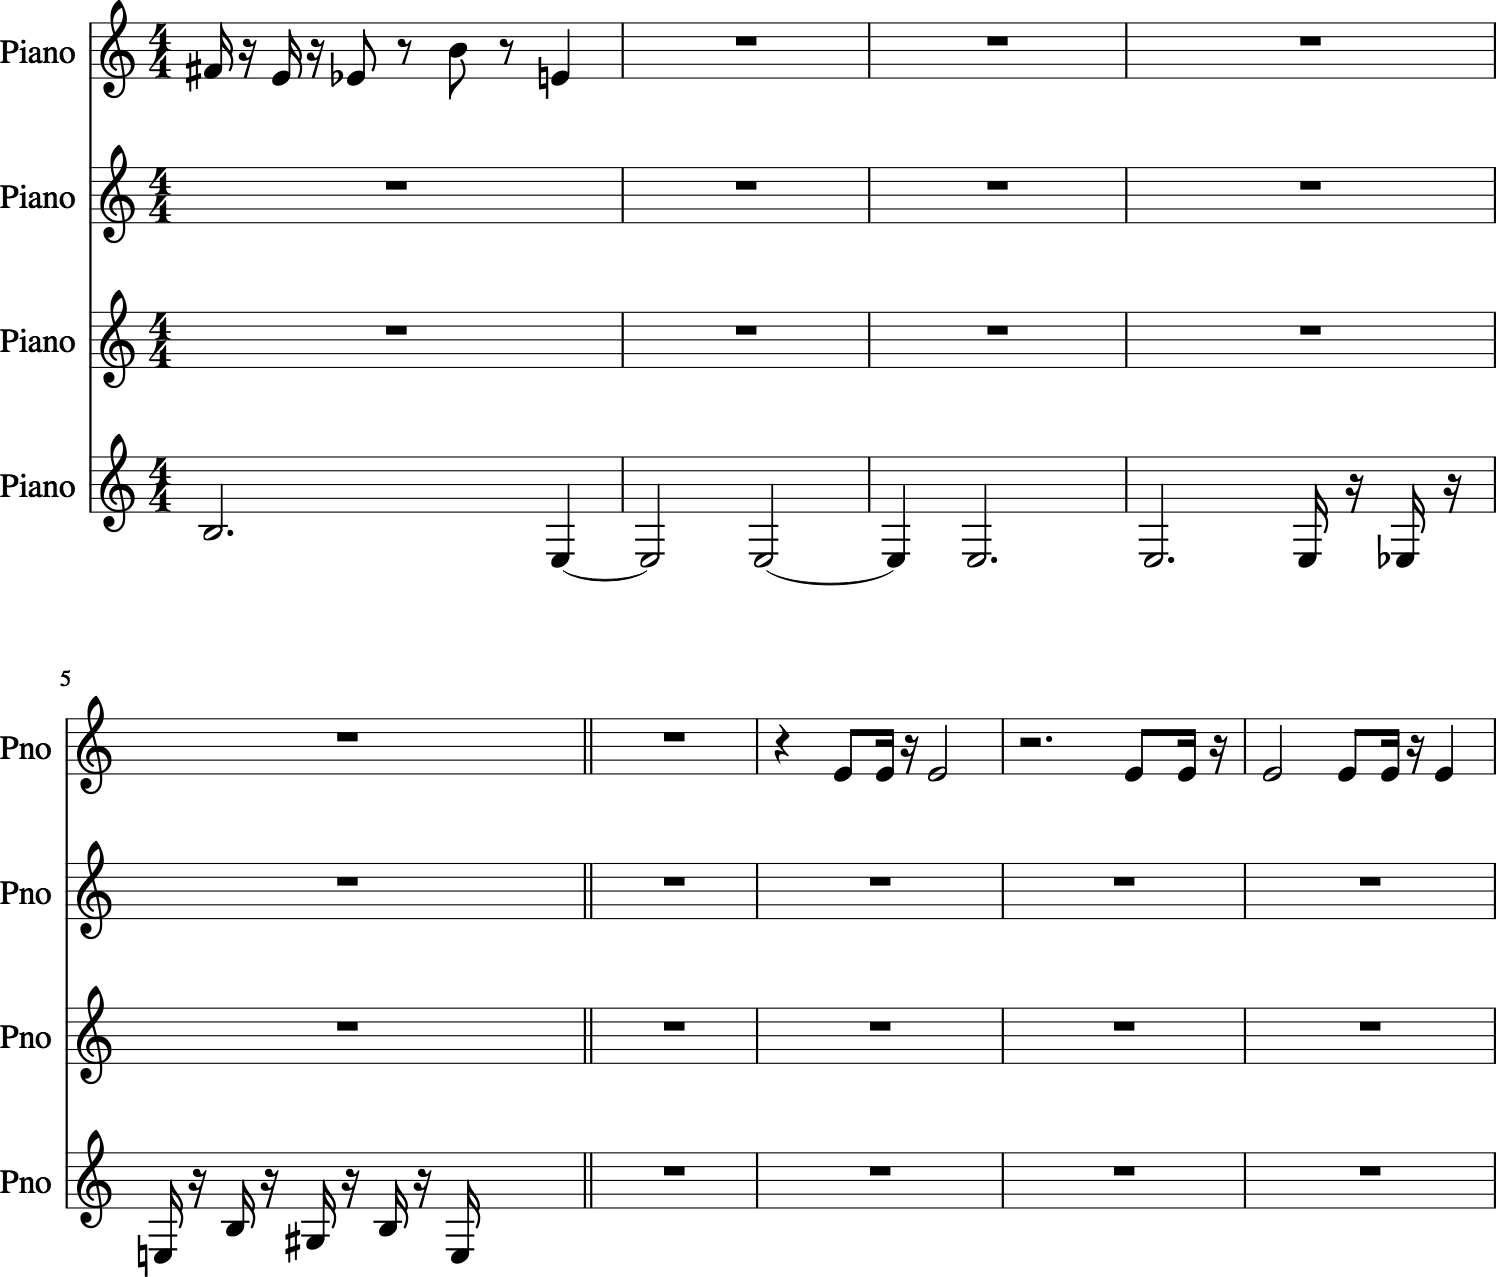

In [14]:
new_score.measures(28, 36).show()

In [15]:
# Write result to MIDI file
file = mc.midi.translate.streamToMidiFile(new_score)
file.open(PATH_OUT, 'wb')
file.write()
file.close()